`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2021/2022`   

In [1]:
# настройка ширины страницы блокнота .......................................
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# расширение watermark для вывода информации о версиях пакетов
# https://github.com/rasbt/watermark
#%load_ext watermark

# Лабораторная работа №5: Методы, основанные на деревьях решений. Регрессионные деревья. Деревья классификации. Случайный лес. Бустинг.  

В практических примерах ниже показано:   

* как делать перекодировку признаков в номинальной и порядковой шкалах
* как вырастить дерево и сделать обрезку его ветвей   
* как настроить модель бэггинга   
* как вырастить случайный лес  
* как настроить модель бустинга на деревьях решений  
* как подбирать настроечные параметры моделей методом сеточного поиска  

Точность всех моделей оценивается методом перекрёстной проверки по 5 блокам.  

*Модели*: дерево классификации, бэггинг, случайный лес, бустинг, дерево регрессии  
*Данные*: `winequality-white_for_lab.csv`. Источник: https://github.com/aksyuk/MTML/blob/main/Labs/data/winequality-white_for_lab.csv

# Указания к выполнению


## Загружаем пакеты

In [2]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# загрузка файлов по URL
import urllib
# проверка существования файла на диске
from pathlib import Path
# для форматирования результатов с помощью Markdown
from IPython.display import Markdown, display
# перекодировка категориальных переменных
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
# хи-квадрат тест на независимость по таблице сопряжённости
from scipy.stats import chi2_contingency
#  для таймера
import time

# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets

# загрузка пакетов: модели -------------------------------------------------
#  дерево классификации
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
# перекрёстная проверка и метод проверочной выборки
from sklearn.model_selection import cross_val_score, train_test_split
# для перекрёстной проверки и сеточного поиска
from sklearn.model_selection import KFold, GridSearchCV
# бэггинг
from sklearn.ensemble import BaggingClassifier
# случайный лес
from sklearn.ensemble import RandomForestClassifier
# бустинг
from sklearn.ensemble import GradientBoostingClassifier
#  сводка по точности классификации
from sklearn.metrics import classification_report

In [3]:
# константы
#  ядро для генератора случайных чисел
my_seed = 8
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [4]:
# функция форматирования результатов с использованием Markdown
def printmd(string):
    display(Markdown(string))
    
# функции для попарной конкатенации элементов двух списков
concat_func_md = lambda x, y: '`' + str(x) + "`:&ensp;&ensp;&ensp;&ensp;" + str(y)
concat_func = lambda x, y: str(x) + ' ' * 4 + str(y)


# функция, которая строит график важности признаков в модели случайного леса
#  источник: https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
def plot_feature_importance(importance, names, model_type) :
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,
                      inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('Важность признаков в модели: ' + model_type)
    plt.xlabel('Важность признака')
    plt.ylabel('')

## Загружаем данные

Набор данных можно загрузить напрямую по ссылке: <https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/winequality-white_for_lab.csv>. Справочник к данным доступен по адресу:<https://github.com/aksyuk/MTML/blob/main/Labs/data/CodeBook_winequality-white_for_lab.md>.

In [5]:
# читаем таблицу из файла .csv во фрейм
fileURL = 'https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/winequality-white_for_lab.csv'
DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (4898, 13)


In [6]:
DF_raw = DF_raw.drop(["residual_sugar", "free_sulfur_dioxide", "quality"], axis = 1)

In [7]:
# типы столбцов
DF_raw.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
chlorides               float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
Y                         int64
dtype: object

Посмотрим на столбцы типа `int`.   

In [8]:
# первые 7 строк столбцов типа int64
DF_raw.loc[:, DF_raw.columns[DF_raw.dtypes == 'int64']].head(7)

,Y
0,1
1,1
2,1
3,1
4,1
5,1
6,1


Функция построения дерева классификации `DecisionTreeClassifier()` требует числовых порядковых значений переменных. Видно, что столбцы типа `int64` бинарные (`Y`), их преобразовывать нет необходимости.

Отложим 15% наблюдений для прогноза.  

In [9]:
# наблюдения для моделирования
DF = DF_raw.sample(frac=0.85, random_state=my_seed)
# отложенные наблюдения
DF_predict = DF_raw.drop(DF.index)

In [10]:
DF.head(5)

,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,density,pH,sulphates,alcohol,Y
4245,7.6,0.35,0.47,0.037,116.0,0.99822,3.04,0.50,9.2,0
945,6.7,0.15,0.29,0.058,105.0,0.99460,3.52,0.44,10.2,1
394,6.8,0.37,0.51,0.044,163.0,0.99760,3.19,0.44,8.8,0
3464,6.9,0.29,0.41,0.046,171.0,0.99537,3.12,0.51,9.6,0
4261,6.0,0.31,0.27,0.042,120.0,0.98952,3.32,0.41,12.7,1


In [11]:
DF_predict.head(5)

,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,density,pH,sulphates,alcohol,Y
5,8.1,0.28,0.40,0.050,97.0,0.9951,3.26,0.44,10.1,1
13,6.6,0.16,0.40,0.044,143.0,0.9912,3.54,0.52,12.4,1
17,6.2,0.66,0.48,0.029,75.0,0.9892,3.33,0.39,12.8,1
21,6.4,0.31,0.38,0.038,102.0,0.9912,3.17,0.35,11.0,1
24,6.6,0.27,0.41,0.052,142.0,0.9951,3.42,0.47,10.0,1


# Предварительный анализ данных  

## Описательные статистики  

Стандартный подсчёт статистик с помощью фунции describe() бесполезен для категориальных столбцов, поэтому рассчитаем частоты категорий по каждому столбцу. Для вывода отчёта воспользуемся форматированием на Markdown.

In [12]:
DF_int = DF_raw.loc[:, DF_raw.columns[DF_raw.dtypes == 'int64']].head(7)

In [13]:
# считаем частоты по столбцам, учитывая пропуски
for col in DF_int.columns:
    freq_col = DF[col].value_counts(dropna=False)
    str_freqs = np.around(freq_col / sum(freq_col), 3).astype(str)
    str_names = freq_col.index.values
    # для вывода в html
    printmd('**' + col + '**</br>' + 
            '</br>'.join(list(map(concat_func_md, str_names, str_freqs))))
    # для сохранения в pdf
    # print('\n', col, '\n', 
    #       '\n'.join(list(map(concat_func, str_names, str_freqs))))

**Y**</br>`1`:&ensp;&ensp;&ensp;&ensp;0.664</br>`0`:&ensp;&ensp;&ensp;&ensp;0.336

In [14]:
# считаем пропуски в столбцах, выводим ненулевые значения
nas = DF.isna().sum()
nas = np.around(nas / DF.shape[0], 3)
nas[nas > 0]

Series([], dtype: float64)

Пропуски отсутствуют.

## Распределение предикторов внутри классов по зависимой переменной

Воспользуемся критерием согласия Хи-квадрат, который рассчитывается по таблице сопряжённости. Нулевая гипотеза теста: распределение долей в таблице сопряжённости случайно, т.е. два показателя независимы друг от друга.
Проведём тест для всех пар "объясняющая переменная" – "зависимая переменная" и выведем те пары, для которых соответствующее критерию p-значение больше 0.05 (т.е. нулевая гипотеза принимается, переменные независимы).

In [15]:
for col in DF.columns[:10] :
    con_tab = pd.crosstab(DF[col], DF['Y'])
    c, p, dof, expected = chi2_contingency(con_tab)
    if p > 0.05 :
        print(col, 'и Y',
              '\nH_0: переменные распределены независимо друг от друга', 
              '\nP-значение:', np.around(p, 4))

# Модель дерева  

В этом разделе построим:  

* дерево классификации  
* дерево классификации с обрезкой ветвей  


## Дерево на всех признаках    

Построим модель и выведем изображение дерева в виде текста.  

In [16]:
# выращиваем дерево на всех объясняющих
X = DF.drop(['Y'], axis=1)
y = DF['Y']

# классификатор
cls_one_tree = DecisionTreeClassifier(criterion='entropy',
                                      random_state=my_seed)

tree_full = cls_one_tree.fit(X, y)

# выводим количество листьев (количество конечных узлов)
tree_full.get_n_leaves()

620

In [17]:
# глубина дерева: количество узлов от корня до листа
#  в самой длинной ветви
tree_full.get_depth()

23

Очевидно, дерево получилось слишком большое для отображения в текстовом формате. Графическая визуализация тоже не поможет в данном случае. Посчитаем показатели точности с перекрёстной проверкой.  

In [18]:
# будем сохранять точность моделей в один массив:
score = list()
score_models = list()

# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=cls_one_tree, X=X, y=y, cv=5,
                     scoring='accuracy')

# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('one_tree')

print('Acc с перекрёстной проверкой',
      '\nдля модели', score_models[0], ':', score[0])

Acc с перекрёстной проверкой 
для модели one_tree : 0.757


Значение точности достаточно неплохое.

## Дерево с обрезкой ветвей   

Подберём оптимальное количество ветвей, которое максимизирует $Acc$, для экономии времени рассчитанный методом проверочной выборки.  

In [19]:
# рассчитываем параметры alpha для эффективных вариантов обрезки ветвей
path = cls_one_tree.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print('Всего значений alpha:', len(ccp_alphas))
print('Энтропия листьев для первых 5 значений alpha:', impurities[:5])

Всего значений alpha: 340
Энтропия листьев для первых 5 значений alpha: [0.         0.00093686 0.00187371 0.00235414 0.00283456]


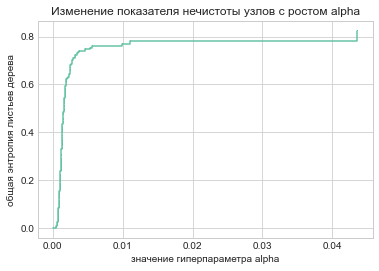

In [20]:
# изображаем на графике
plt.plot(ccp_alphas[:-1], impurities[:-1], marker=',', drawstyle="steps-post")
plt.xlabel("значение гиперпараметра alpha")
plt.ylabel("общая энтропия листьев дерева")
plt.title("Изменение показателя нечистоты узлов с ростом alpha")
plt.show()

In [21]:
# обучающая и тестовая выборки, чтобы сэкономить время
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=my_seed)

# модели
clfs = list()

# таймер
tic = time.perf_counter()
# цикл по значениям alpha
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=my_seed, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# таймер
toc = time.perf_counter()
print(f"Расчёты по обрезке дерева заняли {toc - tic:0.2f} секунд")

Расчёты по обрезке дерева заняли 7.60 секунд


In [22]:
# извлекаем характеристики глубины и точности
#  таймер
tic = time.perf_counter()
node_counts = [clf.tree_.node_count for clf in clfs]
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
#  таймер
toc = time.perf_counter()
print(f"Расчёты показателей точности заняли {toc - tic:0.2f} секунд")

Расчёты показателей точности заняли 1.66 секунд


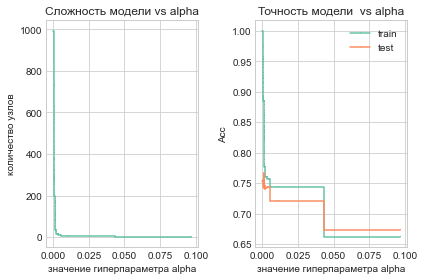

In [23]:
# изображаем на графике
fig, ax = plt.subplots(1, 2)

# график глубины дерева
ax[0].plot(ccp_alphas, node_counts, marker=',', drawstyle="steps-post")
ax[0].set_xlabel("значение гиперпараметра alpha")
ax[0].set_ylabel("количество узлов")
ax[0].set_title("Сложность модели vs alpha")

# график точности
ax[1].plot(ccp_alphas, train_scores, marker=',', label='train',
           drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores, marker=',', label='test',
           drawstyle="steps-post")
ax[1].set_xlabel("значение гиперпараметра alpha")
ax[1].set_ylabel("Acc")
ax[1].set_title("Точность модели  vs alpha")
ax[1].legend()
fig.tight_layout()

Находим оптимальный размер дерева по максимуму $Acc$ на тестовой выборке.  

In [24]:
# оптимальное количество узлов
opt_nodes_num = node_counts[test_scores.index(max(test_scores))]

# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=clfs[opt_nodes_num], X=X, y=y, cv=5,
                    scoring='accuracy')

# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('pruned_tree')

print('Оптимальное количество узлов:', opt_nodes_num,
      '\nсоответствующая Acc на тестовой:', np.around(max(test_scores), 3),
      '\n\nAcc с перекрёстной проверкой',
      '\nдля модели', score_models[1], ':', score[1])

Оптимальное количество узлов: 77 
соответствующая Acc на тестовой: 0.767 

Acc с перекрёстной проверкой 
для модели pruned_tree : 0.745


Посмотрим на характеристики глубины и сложности построенного дерева с обрезкой ветвей.

In [25]:
# выводим количество листьев (количество узлов)
clfs[opt_nodes_num].get_n_leaves()

149

In [26]:
# глубина дерева: количество узлов от корня до листа
#  в самой длинной ветви
clfs[opt_nodes_num].get_depth()

15

---

📚 **Пример визуализации небольшого дерева**

Лучшее дерево с обрезкой по-прежнему слишком велико для визуализации. Для примера нарисуем одно из небольших деревьев с обрезкой и выведем его же в виде текста.  

In [27]:
# находим деревья с количеством листьев меньше 20
[i for i in node_counts if i < 20]

[15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 13,
 13,
 13,
 11,
 11,
 11,
 11,
 11,
 9,
 9,
 7,
 7,
 5,
 5,
 3,
 1]

Количество узлов: 11 
Точность дерева на тестовой: 0.744


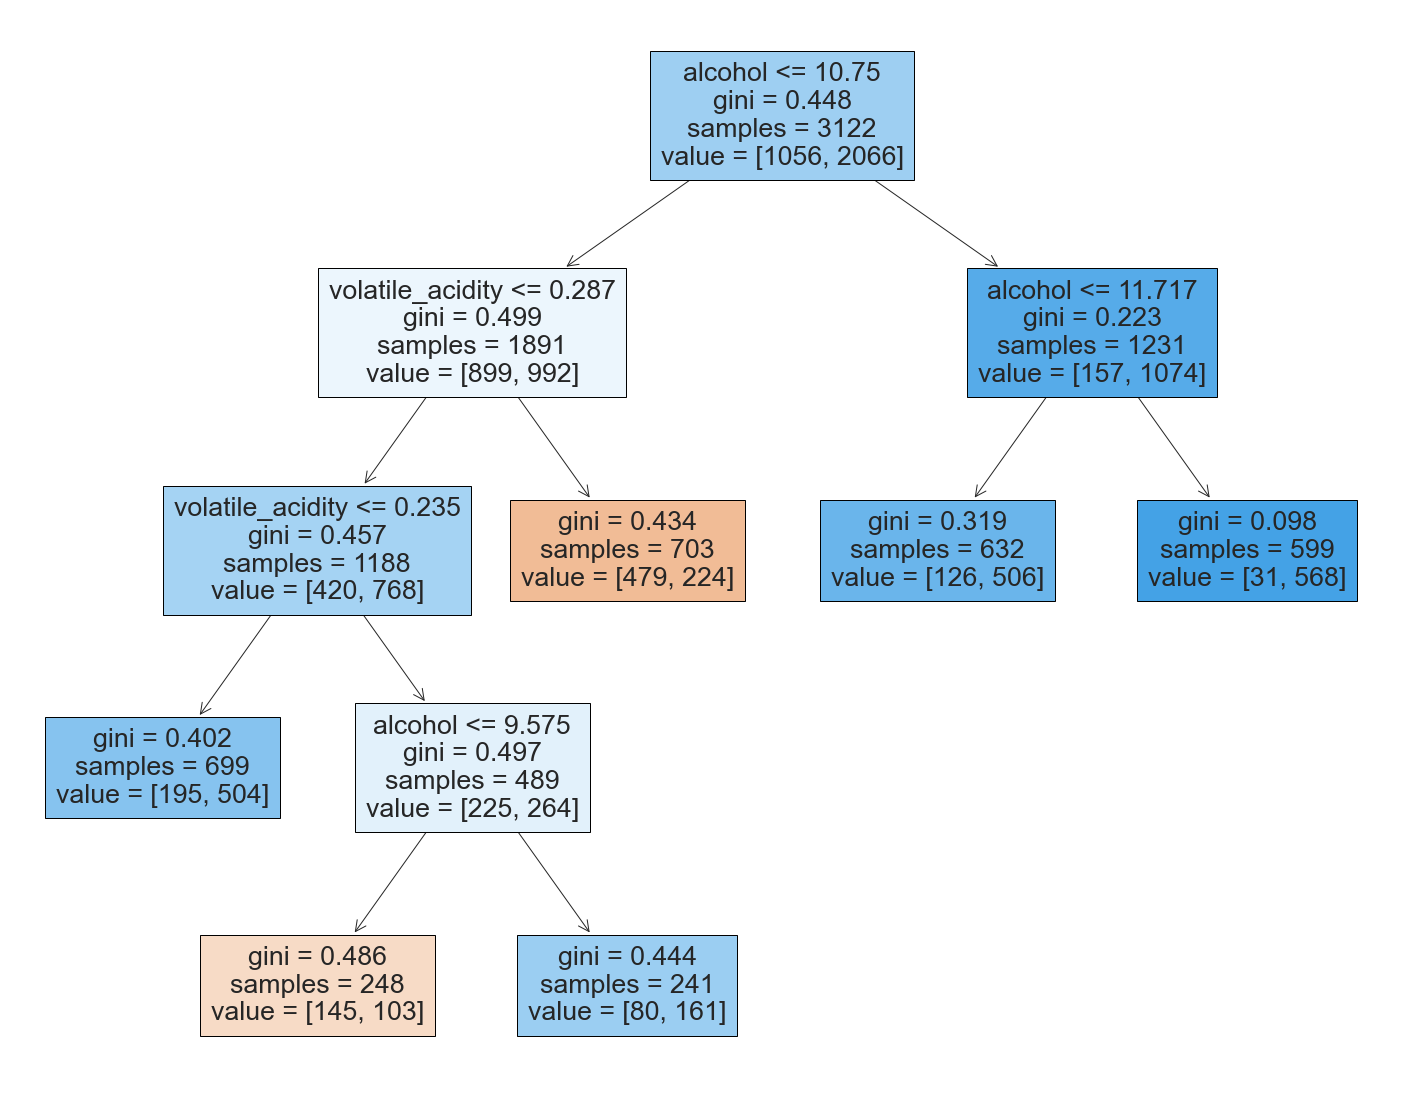

In [28]:
# визуализация на схеме НА ПРИМЕРЕ МАЛЕНЬКОГО ДЕРЕВА
nodes_num = 11
print('Количество узлов:', nodes_num,
      '\nТочность дерева на тестовой:', 
      np.around(test_scores[node_counts.index(nodes_num)], 3))

fig = plt.figure(figsize=(25,20))
_ = plot_tree(clfs[node_counts.index(nodes_num)], 
              filled=True, 
              feature_names=list(X.columns))

In [29]:
# визуализируем дерево в виде текстовой схемы
viz = export_text(clfs[node_counts.index(nodes_num)], 
                  feature_names=list(X.columns))
print(viz)

|--- alcohol <= 10.75
|   |--- volatile_acidity <= 0.29
|   |   |--- volatile_acidity <= 0.23
|   |   |   |--- class: 1
|   |   |--- volatile_acidity >  0.23
|   |   |   |--- alcohol <= 9.58
|   |   |   |   |--- class: 0
|   |   |   |--- alcohol >  9.58
|   |   |   |   |--- class: 1
|   |--- volatile_acidity >  0.29
|   |   |--- class: 0
|--- alcohol >  10.75
|   |--- alcohol <= 11.72
|   |   |--- class: 1
|   |--- alcohol >  11.72
|   |   |--- class: 1



# Случайный лес  



У модели случайного леса два настроечных параметра: количество деревьев $B$ и количество признаков для построения отдельного дерева $m$. Настроим сеточный поиск для их подбора.  

In [30]:
# сколько столбцов в обучающих данных (p)
X_m = X.shape[1]
# возьмём значения для m: p, p/2, sqrt(p) и log2(p)
ms = np.around([X_m, X_m / 2, np.sqrt(X_m), np.log2(X_m)]).astype(int)
ms

array([9, 4, 3, 3])

In [31]:
# настроим параметры случайного леса с помощью сеточного поиска
param_grid = {'n_estimators' : [10, 20, 30, 40, 50],
              'max_features' : ms}

# разбиения для перекрёстной проверки
kfold = KFold(n_splits=5, random_state=my_seed, shuffle=True)

# таймер
tic = time.perf_counter()
clf = GridSearchCV(RandomForestClassifier(DecisionTreeClassifier()),
                   param_grid, scoring='accuracy', cv=kfold)
random_forest = clf.fit(X, y)
# таймер
toc = time.perf_counter()
print(f"Сеточный поиск занял {toc - tic:0.2f} секунд", sep='')

Сеточный поиск занял 30.81 секунд


In [32]:
# точность лучшей модели
np.around(random_forest.best_score_, 3)

0.822

In [33]:
# количество деревьев у лучшей модели
random_forest.best_estimator_.get_params()['n_estimators']

50

In [34]:
# количество объясняющих у лучшей модели
random_forest.best_estimator_.get_params()['max_features']

3

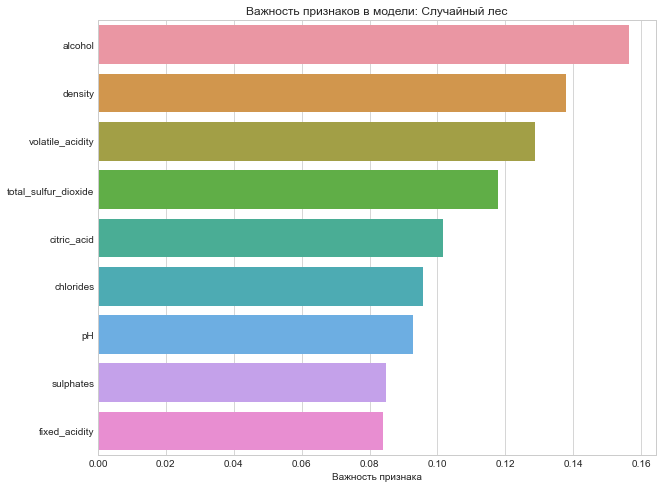

In [35]:
# рисуем график относительной важности каждого признака
plot_feature_importance(random_forest.best_estimator_.feature_importances_,
                        X.columns, 'Случайный лес')

In [36]:
# записываем точность
score.append(np.around(random_forest.best_score_, 3))
score_models.append('random_forest_GS')

print('Acc с перекрёстной проверкой',
      '\nдля модели', score_models[2], ':', score[2])

Acc с перекрёстной проверкой 
для модели random_forest_GS : 0.822



# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенных моделей.  

In [37]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,one_tree,0.757
1,pruned_tree,0.745
2,random_forest_GS,0.822


Все модели показывают среднюю точность по показателю $Acc$, при этом самой точной оказывается модель случайного леса. Сделаем прогноз на отложенные наблюдения.   

In [38]:
# данные для прогноза
X_pred = DF_predict.drop(['Y'], axis=1)
# строим прогноз
y_hat = random_forest.best_estimator_.predict(X_pred)
# характеристики точности
print(classification_report(DF_predict['Y'], y_hat))

              precision    recall  f1-score   support

           0       0.77      0.70      0.73       243
           1       0.86      0.90      0.88       492

    accuracy                           0.83       735
   macro avg       0.81      0.80      0.80       735
weighted avg       0.83      0.83      0.83       735



Приведем ниже точность моделей из упражнения 4.

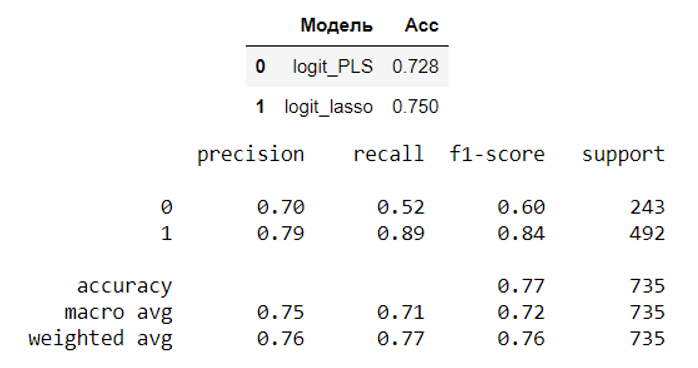

Точность полученной модели оказалась лучше, чем у моделей из упражнения 4.